In [1]:
from tensorflow.keras.models import load_model
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import string
import unicodedata
from tqdm import tqdm
import spacy
from gensim.models import Word2Vec
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [2]:
# Encontra diretorio atual
atual_dir = os.getcwd()

# Acessa arquivo pkl das noticias
parent_dir = os.path.split(atual_dir)

caminho_modelo = os.path.join(parent_dir[0],"Treinamento\\LSTMStacked_model.h5")
caminho_X_test = os.path.join(parent_dir[0],"Treinamento\\X_test_LSTMStacked.npy")
caminho_y_test = os.path.join(parent_dir[0],"Treinamento\\y_test_LSTMStacked.npy")

# Carrega arquivos pertinentes ao treinamento da rede neural e X_test e y_test (usados na avaliação de resultados)
model = load_model(caminho_modelo)
X_test = np.load(caminho_X_test)
y_test = np.load(caminho_y_test)

In [3]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print('Perda final:', loss)
print('Acurácia final:', accuracy)
print('Precisão final:', precision)
print('Recall final:', recall)

Perda final: 0.6116008758544922
Acurácia final: 0.6754412055015564
Precisão final: 0.9240121841430664
Recall final: 0.37005478143692017


In [4]:
# Faz as previsões do modelo para o conjunto de teste
y_pred = model.predict(X_test)

105/105 [==============================] - 9s 68ms/step


In [5]:
#Transforma as previsões de volta em rótulos
y_pred_labels = np.round(y_pred)
y_true_labels = np.round(y_test)

# Calcula a matriz de confusão
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)

conf_mat

array([[1650,   50],
       [1035,  608]], dtype=int64)

In [ ]:
# Encontra diretorio atual
atual_dir = os.getcwd()

# Acessa arquivo pkl das noticias
parent_dir = os.path.split(atual_dir)

parent_dir = os.path.split(parent_dir[0])

parent_dir = os.path.split(parent_dir[0])

# Carrega dataframe salvo em formato pickle
caminho_noticias = os.path.join(parent_dir[0],"Pre-processamento\\df_pre_processado.pkl")

with open(caminho_noticias, 'rb') as f:
    df = pickle.load(f)

In [7]:
# Total de classes
classes = df['label'].nunique()

In [ ]:
# Lê o arquivo .csv
caminho_csv = os.path.join(parent_dir[0], "Pre-processamento\\noticias_dados_limpos.csv")
df_csv = pd.read_csv(caminho_csv)

# Cria um objeto LabelEncoder
le = LabelEncoder()

# Transforma os rótulos de categorias para variáveis categóricas
df_csv['label'] = le.fit_transform(df_csv['Categoria'])

# Obtém os nomes das classes
nomes_classes = le.classes_

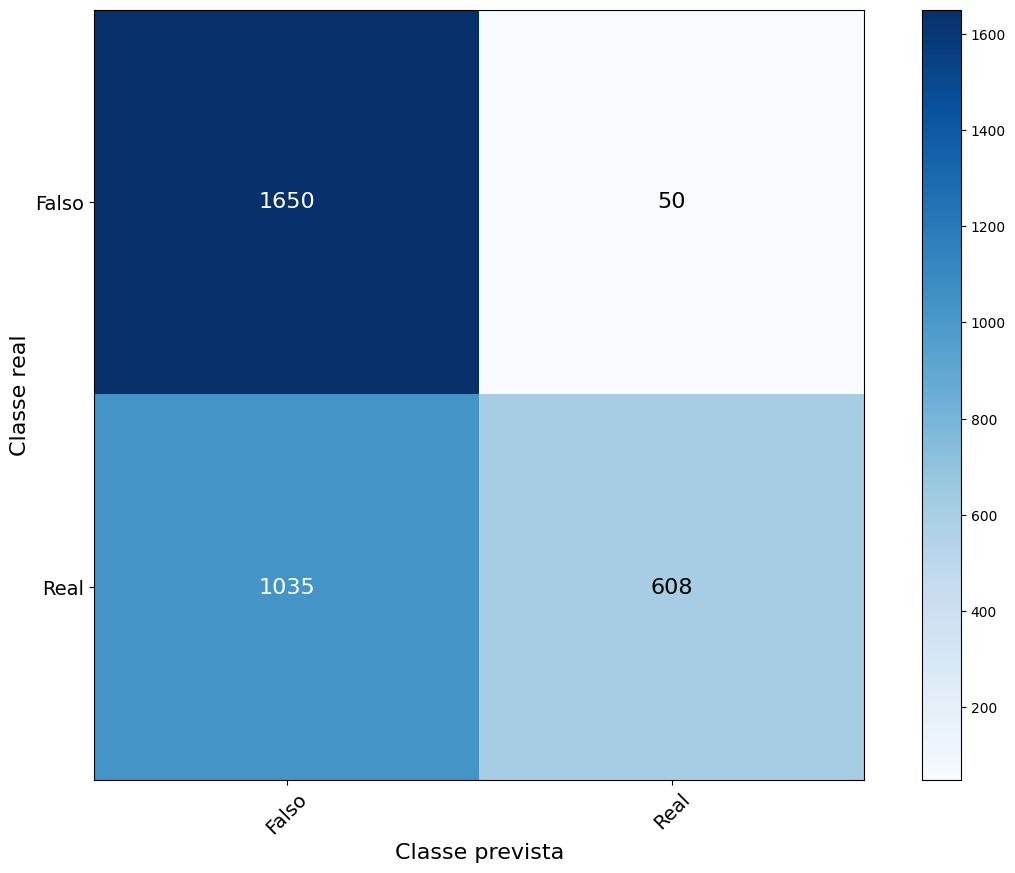

In [9]:
# Define o tamanho da figura
plt.figure(figsize=(15, 10))

# Define mapa de cores
cmap = plt.cm.Blues

# Plota matriz de confusão
plt.imshow(conf_mat, cmap=cmap)
plt.colorbar()

# Define tamanhos de fontes para os rótulos dos eixos e classes
tamanho_fonte_rotulos = 14
tamanho_fonte_texto = 16

# Adiciona rótulos aos eixos e classes
plt.xticks([int(i) for i in range(classes)], nomes_classes, rotation=45, fontsize=tamanho_fonte_rotulos)
plt.yticks([int(i) for i in range(classes)], nomes_classes, fontsize=tamanho_fonte_rotulos)

# Determina a cor e tamanho do texto para cada valor na matriz
for i in range(classes):
    for j in range(classes):
        valor = conf_mat[i, j]
        cor_fundo = cmap(valor / conf_mat.max())  # Normaliza valor para cmap
        brilho = (0.299 * cor_fundo[0] + 0.587 * cor_fundo[1] + 0.114 * cor_fundo[2])  # Calcula brilho da cor

        # Define a cor do texto com base no brilho da cor de fundo
        cor_texto = 'white' if brilho < 0.5 else 'black'
        
        # Exibe o valor no centro do quadrante com tamanho maior
        plt.text(j, i, str(valor), ha='center', va='center', color=cor_texto, fontsize=tamanho_fonte_texto)

# Adiciona rótulos dos eixos
plt.xlabel('Classe prevista', fontsize=tamanho_fonte_rotulos + 2)
plt.ylabel('Classe real', fontsize=tamanho_fonte_rotulos + 2)

# Mostra o plot
plt.show()

In [10]:
# Calcula precisão, recall e f1-score para cada classe
precisions = []
recalls = []
f1_scores = []
for i in range(classes):
    precision = precision_score(y_true=(y_true_labels == i), y_pred=(y_pred_labels == i), zero_division=0)
    recall = recall_score(y_true=(y_true_labels == i), y_pred=(y_pred_labels == i), zero_division=0)
    f1 = f1_score(y_true=(y_true_labels == i), y_pred=(y_pred_labels == i), zero_division=0)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Printa resultados com nomes das classes
for i in range(classes):
    print(f"Classe '{nomes_classes[i]}': Precisão={precisions[i]:.4f}, Recall={recalls[i]:.4f}, F1-Score={f1_scores[i]:.4f}")

# Calcula e printa a média dos f1-scores
f1_average = np.mean(f1_scores)
print(f"F1-Score médio: {f1_average:.4f}")


Classe 'Falso': Precisão=0.6145, Recall=0.9706, F1-Score=0.7526
Classe 'Real': Precisão=0.9240, Recall=0.3701, F1-Score=0.5285
F1-Score médio: 0.6405


In [ ]:
# Carrega o valor de max_length de um arquivo pickle
caminho_max_length = os.path.join(parent_dir[0],"Pre-processamento\\max_length.pkl")
with open(caminho_max_length, 'rb') as f:
    max_length = pickle.load(f)

In [12]:
# Habilita tqdm para os métodos de progressão do pandas (progress_apply)
tqdm.pandas()

# Modelo de linguagem 'pt_core_news_lg' do spacy utilizado para processamento de texto em português
# Desabilita os componentes 'parser' e 'ner', já que não são necessários para a lematização
modelo_spacy_nlp = spacy.load("pt_core_news_lg", disable=["parser", "ner"])

def preprocessamento_dados(df, coluna_texto):
# Realiza o pré-processamento dos dados de um texto em um Dataframe do Pandas.
# Realiza a remoção de pontuação, números e stop words, converte para minúsculas, remove acentos e símbolos diversos, e aplica lematização. 

    # Remove pontuação
    print("Removendo pontuação...")
    tradutor = str.maketrans('', '', string.punctuation)# Mapeamento de ocorrências de string.punctuation para None
    df[coluna_texto] = df[coluna_texto].progress_apply(lambda x: x.translate(tradutor))

    # Remove números
    print("Removendo números...")
    tradutor = str.maketrans('', '', string.digits)
    df[coluna_texto] = df[coluna_texto].progress_apply(lambda x: x.translate(tradutor))

    # Remove acentos e símbolos diversos
    print("Removendo acentos e símbolos...")
    def remove_acentos_e_simbolos(text):
        try:
            return ''.join(c for c in unicodedata.normalize('NFKD', text) if not unicodedata.combining(c) and unicodedata.category(c) != 'Mn')
        except TypeError:
            return ''


    df[coluna_texto] = df[coluna_texto].progress_apply(lambda x: remove_acentos_e_simbolos(x))
    
    # Converte para minúsculas
    print("Convertendo para minúsculas...")
    df[coluna_texto] = df[coluna_texto].progress_apply(lambda x: x.lower())

    # Lematização
    print("Computando Lematização...")
    def lematizar_texto(doc):
        return [token.lemma_ for token in doc if not token.is_stop]

    n_chunks = 10  # Ajuste esse valor de acordo com o tamanho da base de dados e a memória disponível no sistema
    chunks = np.array_split(df, n_chunks) # Divide o dataframe em várias partes

    chunks_processados = []
    for i, chunk in enumerate(chunks):
        print(f"Processando segmento {i + 1} de {n_chunks}")
        chunk_processado = chunk.copy() # Cria uma cópia para realizar o processamento
        
        chunk_processado[coluna_texto] = [lematizar_texto(doc) for doc in tqdm(modelo_spacy_nlp.pipe(chunk[coluna_texto].astype(str), batch_size=100, disable=['parser', 'ner']), total=len(chunk[coluna_texto]))]

        chunks_processados.append(chunk_processado)

    df_concatenado = pd.concat(chunks_processados) # Concatena os DataFrames processados

    df[coluna_texto] = df_concatenado[coluna_texto] # Atribui a coluna 'texto' processada de volta ao dataframe original
    
    # Remove tokens com espaços vazios
    print("Remover tokens com espaços vazios...")
    df['Texto'] = df['Texto'].progress_apply(lambda x: [token for token in x if token.strip()])

In [ ]:
# Encontra diretorio atual
atual_dir = os.getcwd()

# Acessa arquivo pkl das noticias
parent_dir = os.path.split(atual_dir)

parent_dir = os.path.split(parent_dir[0])

parent_dir = os.path.split(parent_dir[0])

caminho_model_word2vec = os.path.join(parent_dir[0], "Pre-processamento\\model_word2vec.model")

# Carrega o modelo Word2Vec para um arquivo
model_word2vec = Word2Vec.load(caminho_model_word2vec)

In [14]:
# 'word_to_index' é um dicionário que mapeia cada palavra ao seu índice correspondente.
word_to_index = {}

# 'index_to_word' é um dicionário que mapeia cada índice à palavra correspondente.
index_to_word = {}

# Itera sobre a lista de palavras únicas obtida do modelo Word2Vec
for i, word in enumerate(model_word2vec.wv.index_to_key):
    # Atribui a palavra ao índice i + 1 no dicionário 'word_to_index'.
    # Os índices começam em 1 para reservar o índice 0 para preenchimento (padding) quando necessário.
    word_to_index[word] = i + 1
    
    # Atribui o índice i + 1 à palavra no dicionário 'index_to_word'.
    index_to_word[i + 1] = word

value = """Conselho de Segurança da ONU aprova resolução de cessar-fogo imediato em Gaza
Texto aprovado estipula que a pausa aconteça durante o Ramadã, que começou em 10 de março e vai até 9 de abril. Documento é de cumprimento obrigatório, mas ONU não tem poder coercitivo. Secretário-geral da ONU, Antonio Guterres, pediu que o governo israelense acatasse a decisão do conselho.
O Conselho de Segurança da Organização das Nações Unidas (ONU) aprovou nesta segunda-feira (25) uma resolução de cessar-fogo imediato na Faixa de Gaza.
A resolução, feita por um grupo de dez países rotativos liderados por Moçambique, é a primeira que o conselho conseguiu aprovar sobre um cessar-fogo no território palestino.

Israel promove uma ofensiva militar no território palestino desde que terroristas do Hamas invadiram o território israelense e mataram centenas de pessoas, em outubro de 2023.

A aprovação, no entanto, não uma solução para a guerra. O desafio agora é garantir que os atores envolvidos nela - o governo de Israel e o grupo terrorista - cumpram as determinações exigidas no texto da ONU.

Isso porque, embora as resoluções do Conselho de Segurança sejam juridicamente vinculativas, na prática acabam ignoradas por muitos países.

O secretário-geral da ONU, Antonio Guterres, pediu que o governo israelense acatasse a decisão do conselho.

Do que se trata
O texto determina um cessar-fogo durante o mês do Ramadã, o período sagrado para os muçulmanos — que começou dia 10 e termina em 9 de abril—, mas pede que a trégua aumente até virar permanente.

A resolução também pede a "libertação imediata e incondicional de reféns" e “a necessidade urgente de expandir o fluxo” de ajuda humanitária para Gaza.
O Conselho de Segurança é formado por 15 países: cinco com assento permanente (China, França, Rússia, Reino Unido e Estados Unidos) e dez rotativos (Argélia, Equador, Guiana, Japão, Malta, Moçambique, Coréia do Sul, Serra Leoa, Eslovênia e Suíça).

Na semana passada, uma resolução dos EUA pedindo a pausa nos bombardeios foi vetada pela China e pela Rússia, que estão entre os cinco membros permanentes do Conselho de Segurança e, por isso, têm poder de veto.

Proposta dos EUA vetada
A proposta dos EUA, uma mudança de posição de Washington na guerra entre Israel e Hamas, previa o cessar-fogo imediato na guerra entre Israel e o grupo terrorista Hamas, além da libertação de reféns.

Ao justificar seu voto, o embaixador da Rússia na ONU, Vassily Nebenzia, acusou os EUA de falsas promessas e de só reconhecer a necessidade de um cessar-fogo "quando mais de 30 mil habitantes de Gaza já morreram".
"""

# Cria um DataFrame
df_predict = pd.DataFrame(data={'Texto': [value]})

# Faz pré-processamento
preprocessamento_dados(df_predict, 'Texto')

# Converte os dados para serem usados no modelo (rede neural)
preprocessed_articles = df_predict['Texto'].tolist()

sequences_test = []
for tokens in tqdm(preprocessed_articles):
    sequence = []
    for token in tokens:
        if token in word_to_index:
            sequence.append(word_to_index[token])
    sequences_test.append(sequence)
    
padded_example = pad_sequences(sequences_test, maxlen=max_length, padding='post')

# Faz a previsão usando o modelo
predictions = model.predict(padded_example)

Removendo pontuação...


100%|██████████| 1/1 [00:00<?, ?it/s]


Removendo números...


100%|██████████| 1/1 [00:00<?, ?it/s]


Removendo acentos e símbolos...


100%|██████████| 1/1 [00:00<?, ?it/s]


Convertendo para minúsculas...


100%|██████████| 1/1 [00:00<?, ?it/s]
c:\Users\mathe\anaconda3\envs\detector\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Computando Lematização...
Processando segmento 1 de 10


100%|██████████| 1/1 [00:00<00:00, 20.48it/s]


Processando segmento 2 de 10


0it [00:00, ?it/s]


Processando segmento 3 de 10


0it [00:00, ?it/s]


Processando segmento 4 de 10


0it [00:00, ?it/s]


Processando segmento 5 de 10


0it [00:00, ?it/s]


Processando segmento 6 de 10


0it [00:00, ?it/s]


Processando segmento 7 de 10


0it [00:00, ?it/s]


Processando segmento 8 de 10


0it [00:00, ?it/s]


Processando segmento 9 de 10


0it [00:00, ?it/s]


Processando segmento 10 de 10


0it [00:00, ?it/s]


Remover tokens com espaços vazios...


100%|██████████| 1/1 [00:00<?, ?it/s]


1/1 [==============================] - 0s 109ms/step


In [15]:
predictions

array([[0.6898009]], dtype=float32)

In [16]:
# Identifica a classe com a maior probabilidade
predicted_class = np.round(predictions).astype(int)

# Exibe a classe prevista
print(f"Classe prevista: {predicted_class[0][0]}")

predicted_class_name = le.inverse_transform([predicted_class[0][0]]) # Transforma a classe predita de variável categórica para o nome
print(f"Classe prevista (nome): {predicted_class_name[0]}")

Classe prevista: 1
Classe prevista (nome): Real


In [17]:
# 'word_to_index' é um dicionário que mapeia cada palavra ao seu índice correspondente.
word_to_index = {}

# 'index_to_word' é um dicionário que mapeia cada índice à palavra correspondente.
index_to_word = {}

# Itera sobre a lista de palavras únicas obtida do modelo Word2Vec
for i, word in enumerate(model_word2vec.wv.index_to_key):
    # Atribui a palavra ao índice i + 1 no dicionário 'word_to_index'.
    # Os índices começam em 1 para reservar o índice 0 para preenchimento (padding) quando necessário.
    word_to_index[word] = i + 1
    
    # Atribui o índice i + 1 à palavra no dicionário 'index_to_word'.
    index_to_word[i + 1] = word

value = """"Estudo Inovador Afirma que Ficar de Pijama o Dia Todo Aumenta a Produtividade"

Uma pesquisa recente realizada por uma equipe de psicólogos da Universidade de Bem-Estar Mental revelou uma descoberta surpreendente: ficar de pijama durante o dia pode aumentar significativamente a produtividade.

Segundo os pesquisadores, vestir pijamas cria uma sensação de conforto e relaxamento, o que reduz os níveis de estresse e ansiedade. Isso, por sua vez, permite que as pessoas se concentrem mais em suas tarefas e sejam mais eficientes em seu trabalho.

O estudo, que acompanhou mais de mil participantes ao longo de seis meses, descobriu que aqueles que adotaram a prática de trabalhar de pijama relataram uma melhoria notável em sua capacidade de concentração e tomada de decisões. Além disso, muitos participantes relataram sentir-se mais motivados e criativos em suas atividades diárias.

Essa descoberta desafia a noção convencional de que vestir roupas formais é essencial para o sucesso profissional. Os pesquisadores agora estão explorando maneiras de integrar essa prática inovadora em ambientes de trabalho tradicionais, potencialmente revolucionando a cultura corporativa.

Portanto, se você está procurando aumentar sua produtividade, talvez seja hora de abandonar o terno e adotar o conforto do pijama durante o expediente!"""

# Cria um DataFrame
df_predict = pd.DataFrame(data={'Texto': [value]})

# Faz pré-processamento
preprocessamento_dados(df_predict, 'Texto')

# Converte os dados para serem usados no modelo (rede neural)
preprocessed_articles = df_predict['Texto'].tolist()

sequences_test = []
for tokens in tqdm(preprocessed_articles):
    sequence = []
    for token in tokens:
        if token in word_to_index:
            sequence.append(word_to_index[token])
    sequences_test.append(sequence)
    
padded_example = pad_sequences(sequences_test, maxlen=max_length, padding='post')

# Faz a previsão usando o modelo
predictions = model.predict(padded_example)

Removendo pontuação...


100%|██████████| 1/1 [00:00<00:00, 1010.68it/s]


Removendo números...


100%|██████████| 1/1 [00:00<?, ?it/s]


Removendo acentos e símbolos...


100%|██████████| 1/1 [00:00<00:00, 997.22it/s]


Convertendo para minúsculas...


100%|██████████| 1/1 [00:00<00:00, 498.31it/s]
c:\Users\mathe\anaconda3\envs\detector\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Computando Lematização...
Processando segmento 1 de 10


100%|██████████| 1/1 [00:00<00:00, 49.89it/s]


Processando segmento 2 de 10


0it [00:00, ?it/s]


Processando segmento 3 de 10


0it [00:00, ?it/s]


Processando segmento 4 de 10


0it [00:00, ?it/s]


Processando segmento 5 de 10


0it [00:00, ?it/s]


Processando segmento 6 de 10


0it [00:00, ?it/s]


Processando segmento 7 de 10


0it [00:00, ?it/s]


Processando segmento 8 de 10


0it [00:00, ?it/s]


Processando segmento 9 de 10


0it [00:00, ?it/s]


Processando segmento 10 de 10


0it [00:00, ?it/s]

Remover tokens com espaços vazios...



100%|██████████| 1/1 [00:00<?, ?it/s]


1/1 [==============================] - 0s 101ms/step


In [18]:
# Identifica a classe com a maior probabilidade
predicted_class = np.round(predictions).astype(int)

# Exibe a classe prevista
print(f"Classe prevista: {predicted_class[0][0]}")

predicted_class_name = le.inverse_transform([predicted_class[0][0]]) # Transforma a classe predita de variável categórica para o nome
print(f"Classe prevista (nome): {predicted_class_name[0]}")

Classe prevista: 0
Classe prevista (nome): Falso
